In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

In [5]:
# 定义图像分块和嵌入模块
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embedding_size=768):
        """
        Args:
            img_size: 输入图像的大小 (假设为正方形)
            patch_size: 每个图像块的大小 (假设为正方形)
            in_channels: 输入图像的通道数 (例如RGB图像为3)
            embedding_size: 嵌入维度
        """
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.projection = nn.Conv2d(in_channels, embedding_size, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_size))
        self.positonal_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_size))

    def forward(self, x):
        x = self.projection(x)  # (B, embedding_size, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embedding_size, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embedding_size)
        # 添加分类标识符
        cls_tokens = self.cls_token.expand(x.size(0), -1, -1)  # (B, 1, embedding_size)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, num_patches + 1, embedding_size)
        x = x + self.positonal_embedding  # 添加位置嵌入
        return x

In [6]:
# 图像数据生成
def generate_sample_image(img_size: int = 224):
    img = np.random.randint(0, 256, (img_size, img_size, 3), dtype=np.uint8)
    plt.imshow(img)
    plt.title("Sample Image")
    plt.show()
    return torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float()  # (1, 3, H, W)

In [7]:
# Transformer编码器模块
class TransformerBlock(nn.Module):
    def __init__(self, embedding_size=768, num_heads=12, dropout=0.1, forward_expansion=4):
        """
        Args:
            embedding_size: 输入嵌入的维度
            num_heads: 多头注意力机制的头数
            dropout: dropout概率
            forward_expansion: 前馈神经网络的扩展因子
        """
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embedding_size, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(embedding_size)
        self.norm2 = nn.LayerNorm(embedding_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embedding_size, forward_expansion * embedding_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embedding_size, embedding_size),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query):
        """
        Args:
            value: 输入张量，形状为 (N, sequence_length, batch_size, embedding_size)
            key: 输入张量，形状为 (N, sequence_length, batch_size, embedding_size)
            query: 输入张量，形状为 (N, sequence_length, batch_size, embedding_size)
        Returns:
            输出张量，形状为 ((N, sequence_length, batch_size, embedding_size)
        """
        attn_output = self.attention(value, key, query)[0]
        norm1_out = self.norm1(query + self.dropout(attn_output))
        forward_output = self.feed_forward(norm1_out)
        norm2_out = self.norm2(norm1_out + self.dropout(forward_output))
        return norm2_out

In [8]:
# Vision Transformer模型定义
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embedding_size=768,
                 num_layers=12, num_heads=12, dropout=0.1, forward_expansion=4, num_classes=1000):
        """
        Args:
            img_size: 输入图像的大小 (假设为正方形)
            patch_size: 每个图像块的大小 (假设为正方形)
            in_channels: 输入图像的通道数 (例如RGB图像为3)
            embedding_size: 嵌入维度
            num_layers: Transformer编码器层数
            num_heads: 多头注意力机制的头数
            dropout: dropout概率
            forward_expansion: 前馈神经网络的扩展因子
            num_classes: 分类任务的类别数
        """
        super(VisionTransformer, self).__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embedding_size)
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(embedding_size, num_heads, dropout, forward_expansion) for _ in range(num_layers)]
        )
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embedding_size),
            nn.Linear(embedding_size, num_classes)
        )

    def forward(self, x):
        x = self.patch_embedding(x)  # (B, num_patches + 1, embedding_size)
        for block in self.transformer_blocks:
            x = block(x, x, x)
        x = self.to_cls_token(x[:, 0])  # 取分类标识符对应的输出
        x = self.mlp_head(x)
        return x

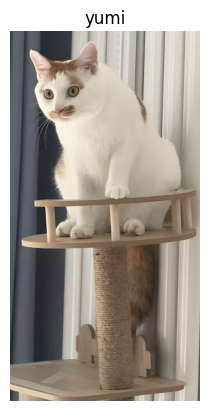

In [21]:
# 加载图像
img = Image.open("./yumi.png").convert("RGB")
plt.imshow(img)
plt.title("yumi")
plt.axis('off')
plt.show()

In [15]:
# 图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
img_tensor = transform(img).unsqueeze(0)  # (1, 3,

In [18]:
# 初始化ViT模型
vit_model = VisionTransformer(num_classes=10)
# 前向传播
output = vit_model(img_tensor)
print("Output:", output)  # 应该是 (1, num_classes)
print("Output shape:", output.shape)  # 应该是 (1, num_classes)

Output: tensor([[-0.6117,  0.3148, -0.1825, -0.1535, -0.0476,  0.0206,  0.2612,  0.0051,
          0.5092,  0.3294]], grad_fn=<AddmmBackward0>)
Output shape: torch.Size([1, 10])
